In [1]:
import zipfile
with zipfile.ZipFile('./ICK.zip', 'r') as zip_ref:
    zip_ref.extractall('./')

In [2]:
import numpy as np
import jax.numpy as jnp
from jax import random

from IPython.display import set_matplotlib_formats
set_matplotlib_formats('pdf', 'svg')
import matplotlib
import seaborn as sns
sns.set(font_scale=1.3)
sns.set_style("darkgrid", {"axes.facecolor": ".95"})
import matplotlib.pyplot as plt
from collections import namedtuple

Data = namedtuple(
    'Data',
    ['input1', 'input2', 'target']
)
NOISE_SCALE = 1e-2

# Generate toy data as shown in Bayesian NTK paper but with 2 modalities: $y = x_1\mathrm{sin}(x_2)$

In [3]:
def get_toy_data(key, noise_scale, train_points, test_points, scale=1.0):
    """
    Original repo: https://github.com/bobby-he/bayesian-ntk/blob/master/bayesian_ntk/utils.py
    Bayesian NTK paper: https://arxiv.org/abs/1806.03335
    """
    train_xlim = 2
    test_xlim = 6
    key, x_key1, x_key2, y_key = random.split(key, 4)

    half_train_points = train_points // 2
    train_x1_left = random.uniform(
        x_key1,
        shape = (half_train_points, 1),
        minval = -train_xlim,
        maxval = -train_xlim/3
    )
    train_x2_left = random.uniform(
        x_key2,
        shape = (half_train_points, 1),
        minval = -train_xlim,
        maxval = -train_xlim/3
    )

    train_x1_right = random.uniform(
        x_key1,
        shape = (half_train_points, 1),
        minval = train_xlim/3,
        maxval = train_xlim
    )
    train_x2_right = random.uniform(
        x_key2,
        shape = (half_train_points, 1),
        minval = train_xlim/3,
        maxval = train_xlim
    )

    train_x1 = jnp.concatenate((train_x1_left, train_x1_right))
    train_x2 = jnp.concatenate((train_x2_left, train_x2_right))

    target_fn = lambda x1, x2: x1 * jnp.sin(x2) * scale

    train_y = target_fn(train_x1, train_x2)
    train_y += noise_scale * random.normal(y_key, (train_points, 1))
    train = Data(
        input1 = train_x1,
        input2 = train_x2,
        target = train_y
    )

    test_x1 = jnp.reshape(jnp.linspace(-test_xlim, test_xlim, test_points), (test_points, 1))
    test_x2 = jnp.reshape(jnp.linspace(-test_xlim, test_xlim, test_points), (test_points, 1))
    test_ys = target_fn(test_x1, test_x2)
    test = Data(
        input1 = test_x1,
        input2 = test_x2,
        target = test_ys
    )

    return train, test

In [4]:
def format_plot(ax, x=None, y=None):
    if x is not None:
        ax.set_xlabel(x, fontsize=20)
    if y is not None:
        ax.set_ylabel(y, fontsize=20)

# Only plot x2 vs y
def plot_fn(train, test):
    fig, ax = plt.subplots(1, 1, figsize=(7,6))

    train_x1, train_x2, train_y = train
    ax.plot(train_x2, train_y, color='darkgreen', marker='o', ls='', markersize=7, label='train')

    if test != None:
        test_x1, test_x2, test_y = test
        ax.plot(test_x2, test_y, 'k--', linewidth=3, label='$y=x_1\mathrm{sin}(x_2)$')

    ax.set_xlim([-6., 6.])
    ax.legend()
    format_plot(ax, '$x_2$', '$y$')
    return ax

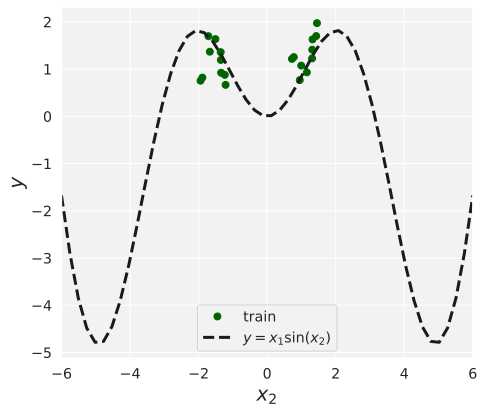

In [5]:
train_data, test_data = get_toy_data(random.PRNGKey(10), NOISE_SCALE, train_points=20, test_points=50)
plot_fn(train_data, test_data)
plt.tight_layout()

# Apply ICK ensemble on the generated toy data

In [ ]:
!pip -q install torchbnn
!pip -q install neural_tangents
!pip -q install vit-pytorch

In [7]:
from sklearn.ensemble import RandomTreesEmbedding
from kernels.kernel_fn import periodic_kernel_nys
from kernels.nn import *
from model.ick import ICK, BayesianICK
from utils.helpers import create_generators_from_data
from utils.train import EnsembleTrainer

In [8]:
# For ICK, transform x1 to higher dimension first
x1_train, x2_train, y_train = np.array(train_data[0]), np.array(train_data[1]), np.array(train_data[2])
x1_test, x2_test, y_test = np.array(test_data[0]), np.array(test_data[1]), np.array(test_data[2])
rt_model = RandomTreesEmbedding(n_estimators=10, max_depth=2, random_state=42)
x1_train = rt_model.fit_transform(x1_train.reshape(-1,1)).toarray()
x1_test = rt_model.fit_transform(x1_test.reshape(-1,1)).toarray()
x_train, x_test = [x1_train, x2_train], [x1_test, x2_test]
data_generators = create_generators_from_data(x_train, y_train, x_test, y_test, None, None, 
                                              train_batch_size=25, test_batch_size=50)

In [ ]:
# Use the Erf activation as specified in Teh et al.
kernel_assignment = ['ImplicitDenseNetKernel', 'ImplicitNystromKernel']
kernel_params = {
    'ImplicitDenseNetKernel': {
        'input_dim': x_train[0].shape[1],
        'latent_feature_dim': 32,
        'num_blocks': 2, 
        'activation': 'erf',
        'num_layers_per_block': 1, 
        'num_units': 512
    }, 
    'ImplicitNystromKernel': {
        'kernel_func': periodic_kernel_nys, 
        'params': ['std','period','lengthscale','noise'], 
        'vals': [1., 2*np.pi, 0.2, 0.5], 
        'trainable': [True, True, True, True], 
        'alpha': 1e-5, 
        'num_inducing_points': 32, 
        'nys_space': [[-np.pi, np.pi]]
    }
}
num_estimators = 300
ensemble = [ICK(kernel_assignment, kernel_params) for _ in range(num_estimators)]
for base_learner in ensemble:
    base_learner.kernels[0].freeze_all_blocks_except_last()
    base_learner.kernels[0].reset_parameters_normal(w_std=0.1, b_std=0.1)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
optim = 'sgd'
optim_params = {
    'lr': 1e-3, 
    'momentum': 0.9, 
}
num_jobs = 1
epochs, patience = 500, 10
trainer = EnsembleTrainer(
    model=ensemble, 
    data_generators=data_generators,
    optim=optim,
    optim_params=optim_params, 
    num_jobs=num_jobs, 
    model_save_dir=None,
    loss_fn=nn.MSELoss(),
    device=device,
    epochs=epochs,
    patience=patience
)
trainer.train()
alpha_train = torch.mean(torch.stack([ensemble[i].kernels[1].get_features() for i in range(len(ensemble))]), axis=0)

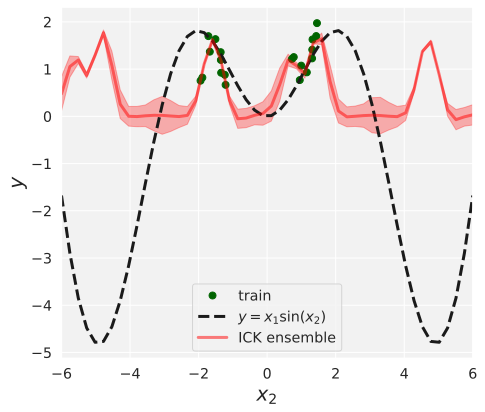

In [10]:
y_test_pred_mean, y_test_pred_std, _ = trainer.predict()
alpha_test = ensemble[0].kernels[1].get_features()
ax = plot_fn(train_data, test_data)
ax.plot(test_data.input2, y_test_pred_mean, 'red', linewidth=3, alpha=0.5, label='ICK ensemble')
ax.fill_between(
    jnp.reshape(test_data.input2, (-1,)),
    y_test_pred_mean - 2 * y_test_pred_std,
    y_test_pred_mean + 2 * y_test_pred_std,
    color='red',
    alpha = 0.3
)
ax.legend()
plt.tight_layout()

# Apply ICK with infinite wide NN kernel on the generated toy data

In [11]:
import neural_tangents as nt
from neural_tangents import stax

In [12]:
# Map x1 into high-dimensional space
train_data_transformed = Data(input1 = jnp.array(x1_train), input2 = train_data[1], target = train_data[2])
test_data_transformed = Data(input1 = jnp.array(x1_test), input2 = test_data[1], target = test_data[2])

params_nn = [list(ensemble[i].kernels[0].parameters()) for i in range(len(ensemble))]
W_std_1 = float(torch.mean(torch.stack([torch.std(params_nn[i][0]) for i in range(len(params_nn))])))
b_std_1 = float(torch.mean(torch.stack([torch.std(params_nn[i][1]) for i in range(len(params_nn))])))
W_std_2 = float(torch.mean(torch.stack([torch.std(params_nn[i][2]) for i in range(len(params_nn))])))
b_std_2 = float(torch.mean(torch.stack([torch.std(params_nn[i][3]) for i in range(len(params_nn))])))
W_std_3 = float(torch.mean(torch.stack([torch.std(params_nn[i][4]) for i in range(len(params_nn))])))
b_std_3 = float(torch.mean(torch.stack([torch.std(params_nn[i][5]) for i in range(len(params_nn))])))

init_fn, apply_fn, kernel_fn = stax.serial(
    stax.Dense(512, W_std=W_std_1, b_std=b_std_1), 
    stax.Erf(),
    stax.Dense(512, W_std=W_std_2, b_std=b_std_2), 
    stax.Erf(),
    stax.Dense(1, W_std=W_std_3, b_std=b_std_3)
)

params_periodic = [list(ensemble[i].kernels[1].parameters()) for i in range(len(ensemble))]
std_ens = float(torch.mean(torch.stack([params_periodic[i][0].detach() for i in range(len(params_periodic))])))
period_ens = float(torch.mean(torch.stack([params_periodic[i][1].detach() for i in range(len(params_periodic))])))
lengthscale_ens = float(torch.mean(torch.stack([params_periodic[i][2].detach() for i in range(len(params_periodic))])))
noise_ens = float(torch.mean(torch.stack([params_periodic[i][3].detach() for i in range(len(params_periodic))])))

def compute_composite_kernel(input_data1, input_data2, alpha_k, alpha_l, nngp_fn, periodic_fn):
    alpha_k = alpha_k.detach()
    alpha_l = alpha_l.detach()
    n1, n2, p = alpha_k.shape[0], alpha_l.shape[0], alpha_k.shape[1]
    # def calculate_covariance(alpha_k, alpha_l, k_kl):
    #     k_kl = torch.from_numpy(np.array(k_kl))
    #     res = torch.zeros((n1, n2))
    #     for k in range(p):
    #         for l in range(p):
    #             if k != l:
    #                 res += torch.outer(alpha_k[:,k],alpha_l[:,l]) * k_kl[k*n1:(k+1)*n1,l*n2:(l+1)*n2]
    #     return jnp.array(res)
    # data_nngp1 = jnp.repeat(input_data1[0], p, axis=0)
    # data_nngp2 = jnp.repeat(input_data2[0], p, axis=0)
    # kernel_nngp = nngp_fn(data_nngp1, data_nngp2, 'nngp')
    kernel_nngp = nngp_fn(input_data1[0], input_data2[0], 'nngp')
    kernel_periodic = jnp.array(periodic_fn(
        x=torch.tensor(np.asarray(input_data1[1])),
        y=torch.tensor(np.asarray(input_data2[1])),
        std=std_ens,
        period=period_ens, 
        lengthscale=lengthscale_ens, 
        noise=noise_ens
    ))
    # return kernel_nngp[:n1,:n2] * kernel_periodic + calculate_covariance(alpha_k, alpha_l, kernel_nngp)
    return kernel_nngp * kernel_periodic

k_train_train = compute_composite_kernel(train_data_transformed, train_data_transformed, alpha_train, alpha_train, kernel_fn, periodic_kernel_nys)
k_test_train = compute_composite_kernel(test_data_transformed, train_data_transformed, alpha_test, alpha_train, kernel_fn, periodic_kernel_nys)
k_test_test = compute_composite_kernel(test_data_transformed, test_data_transformed, alpha_test, alpha_test, kernel_fn, periodic_kernel_nys)

In [13]:
predict_fn = nt.predict.gp_inference(
    k_train_train=k_train_train, 
    y_train=train_data[2], 
    diag_reg=1e-5
)
gp_mean, gp_cov = predict_fn(
    get='nngp', 
    k_test_train=k_test_train, 
    k_test_test=k_test_test
)
gp_mean = jnp.reshape(gp_mean, (-1,))
gp_std = jnp.reshape(jnp.sqrt(jnp.diag(gp_cov)), (-1,))

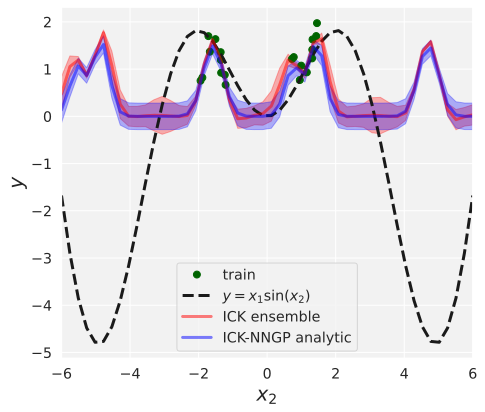

In [14]:
y_test_pred_mean, y_test_pred_std, _ = trainer.predict()
ax = plot_fn(train_data, test_data)
ax.plot(test_data.input2, y_test_pred_mean, 'red', linewidth=3, alpha=0.5, label='ICK ensemble')
ax.fill_between(
    jnp.reshape(test_data.input2, (-1,)),
    y_test_pred_mean - 2 * y_test_pred_std,
    y_test_pred_mean + 2 * y_test_pred_std,
    color='red',
    alpha = 0.3
)
ax.plot(test_data.input2, gp_mean, 'blue', linewidth=3, alpha=0.5, label='ICK-NNGP analytic')
ax.fill_between(
    jnp.reshape(test_data.input2, (-1,)),
    gp_mean - 2 * gp_std, 
    gp_mean + 2 * gp_std,
    color='blue',
    alpha = 0.3
)
ax.legend()
plt.tight_layout()

# Sanity check

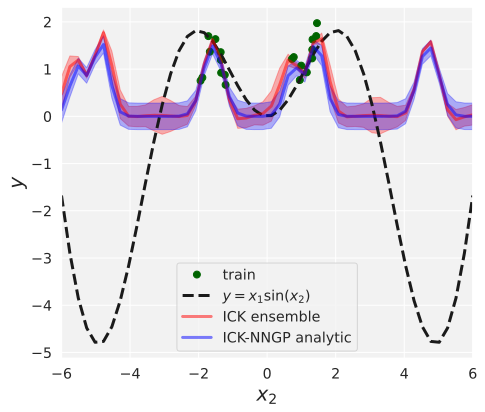

In [15]:
posterior_mean = (k_test_train @ jnp.linalg.inv((k_train_train + 1e-5*jnp.eye(k_train_train.shape[0])))) @ train_data[2]
posterior_cov = k_test_test - (k_test_train @ jnp.linalg.inv((k_train_train + 1e-5*jnp.eye(k_train_train.shape[0])))) @ k_test_train.T
posterior_mean = jnp.reshape(posterior_mean, (-1,))
posterior_std = jnp.reshape(jnp.sqrt(jnp.diag(posterior_cov)), (-1,))

ax = plot_fn(train_data, test_data)
ax.plot(test_data.input2, y_test_pred_mean, 'red', linewidth=3, alpha=0.5, label='ICK ensemble')
ax.fill_between(
    jnp.reshape(test_data.input2, (-1,)),
    y_test_pred_mean - 2 * y_test_pred_std,
    y_test_pred_mean + 2 * y_test_pred_std,
    color='red',
    alpha = 0.3
)
ax.plot(test_data.input2, posterior_mean, 'blue', linewidth=3, alpha=0.5, label='ICK-NNGP analytic')
ax.fill_between(
    jnp.reshape(test_data.input2, (-1,)),
    posterior_mean - 2 * posterior_std, 
    posterior_mean + 2 * posterior_std,
    color='blue',
    alpha = 0.3
)
ax.legend()
plt.tight_layout()